# SEC 10-Q Financial Statement Extractor + Ratio Analysis

**V.9.0 with Comprehensive Financial Ratios & Visualizations**

**Engineer:** Alex Osterneck, CLA, MSCS, MSIT  
**Organization:** ai70000, Ltd.  
**Date:** December 11th, 2025

## Step 1: Install Dependencies

In [ ]:
# Run this first
!pip install requests pandas openpyxl -q

## Step 2: Define SEC 10-Q Fetcher Class

In [ ]:
#!/usr/bin/env python3
import requests
import pandas as pd
from time import sleep
from typing import Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

class SEC10QFetcher:
    def __init__(self, user_agent: str):
        self.base_url = "https://www.sec.gov"
        self.headers = {
            'User-Agent': user_agent,
            'Accept-Encoding': 'gzip, deflate'
        }

    def get_cik_from_ticker(self, ticker: str) -> Optional[str]:
        ticker = ticker.upper().strip()
        try:
            url = "https://www.sec.gov/files/company_tickers.json"
            response = requests.get(url, headers=self.headers, timeout=10)
            response.raise_for_status()
            companies = response.json()
            for company in companies.values():
                if company['ticker'] == ticker:
                    cik = str(company['cik_str']).zfill(10)
                    print(f"✓ Found CIK: {cik}")
                    return cik
            print(f"✗ Ticker '{ticker}' not found")
            return None
        except Exception as e:
            print(f"✗ Error fetching CIK: {e}")
            return None

    def get_latest_10q_info(self, cik: str) -> Optional[Tuple[str, str]]:
        try:
            url = f"https://data.sec.gov/submissions/CIK{cik}.json"
            response = requests.get(url, headers=self.headers, timeout=10)
            response.raise_for_status()
            data = response.json()
            filings = data.get('filings', {}).get('recent', {})
            forms = filings.get('form', [])
            accession_numbers = filings.get('accessionNumber', [])
            filing_dates = filings.get('filingDate', [])
            for i, form in enumerate(forms):
                if form == '10-Q':
                    accession = accession_numbers[i].replace('-', '')
                    print(f"✓ Found 10-Q filed on: {filing_dates[i]}")
                    print(f"  Accession: {accession_numbers[i]}")
                    return (cik.lstrip('0'), accession)
            print("✗ No 10-Q filing found")
            return None
        except Exception as e:
            print(f"✗ Error fetching 10-Q info: {e}")
            return None

    def get_company_facts(self, cik: str) -> Optional[dict]:
        try:
            url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
            print(f"\n  Fetching XBRL data from SEC API...")
            response = requests.get(url, headers=self.headers, timeout=15)
            response.raise_for_status()
            data = response.json()
            print(f"✓ Downloaded XBRL data ({len(str(data)):,} bytes)")
            return data
        except Exception as e:
            print(f"✗ Error fetching XBRL data: {e}")
            return None

    def extract_financials_from_xbrl(self, facts_data: dict, cik_no_zeros: str, accession: str) -> Dict[str, pd.DataFrame]:
        print("\n" + "="*80)
        print("EXTRACTING FINANCIAL STATEMENTS FROM XBRL DATA")
        print("="*80 + "\n")
        results = {'balance_sheet': None, 'income_statement': None, 'cash_flow': None}
        us_gaap = facts_data.get('facts', {}).get('us-gaap', {})
        if not us_gaap:
            print("✗ No US-GAAP data found")
            return results
        print(f"Found {len(us_gaap)} US-GAAP concepts\n")
        target_form = '10-Q'

        balance_sheet_concepts = {
            'Assets': 'Assets', 'AssetsCurrent': 'Current Assets',
            'CashAndCashEquivalentsAtCarryingValue': 'Cash and Cash Equivalents',
            'MarketableSecurities': 'Marketable Securities',
            'ShortTermInvestments': 'Short-term Investments',
            'AccountsReceivableNetCurrent': 'Accounts Receivable, Net',
            'InventoryNet': 'Inventory',
            'PropertyPlantAndEquipmentNet': 'Property, Plant and Equipment, Net',
            'Goodwill': 'Goodwill',
            'IntangibleAssetsNetExcludingGoodwill': 'Intangible Assets, Net',
            'Liabilities': 'Total Liabilities',
            'LiabilitiesCurrent': 'Current Liabilities',
            'AccountsPayableCurrent': 'Accounts Payable',
            'ShortTermBorrowings': 'Short-term Debt',
            'LongTermDebt': 'Long-term Debt',
            'LongTermDebtCurrent': 'Current Portion Long-term Debt',
            'StockholdersEquity': "Stockholders' Equity",
            'CommonStockValue': 'Common Stock',
            'RetainedEarningsAccumulatedDeficit': 'Retained Earnings',
            'LiabilitiesAndStockholdersEquity': 'Total Liabilities and Equity',
        }

        print("Extracting Balance Sheet...")
        balance_sheet = self._extract_statement(us_gaap, balance_sheet_concepts, target_form, accession)
        if balance_sheet is not None:
            results['balance_sheet'] = balance_sheet
            print(f"✓ Balance Sheet: {len(balance_sheet)} line items\n")

        income_statement_concepts = {
            'Revenues': 'Revenue',
            'RevenueFromContractWithCustomerExcludingAssessedTax': 'Revenue',
            'CostOfRevenue': 'Cost of Revenue',
            'CostOfGoodsAndServicesSold': 'Cost of Sales',
            'GrossProfit': 'Gross Profit',
            'OperatingExpenses': 'Operating Expenses',
            'ResearchAndDevelopmentExpense': 'Research and Development',
            'SellingGeneralAndAdministrativeExpense': 'Selling, General and Administrative',
            'OperatingIncomeLoss': 'Operating Income',
            'InterestExpense': 'Interest Expense',
            'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest': 'Income Before Taxes',
            'IncomeTaxExpenseBenefit': 'Income Tax Expense',
            'NetIncomeLoss': 'Net Income',
            'EarningsPerShareBasic': 'EPS - Basic',
            'EarningsPerShareDiluted': 'EPS - Diluted',
        }

        print("Extracting Income Statement...")
        income_statement = self._extract_statement(us_gaap, income_statement_concepts, target_form, accession)
        if income_statement is not None:
            results['income_statement'] = income_statement
            print(f"✓ Income Statement: {len(income_statement)} line items\n")

        cash_flow_concepts = {
            'NetCashProvidedByUsedInOperatingActivities': 'Net Cash from Operating Activities',
            'NetIncomeLoss': 'Net Income',
            'DepreciationDepletionAndAmortization': 'Depreciation and Amortization',
            'PaymentsToAcquirePropertyPlantAndEquipment': 'Capital Expenditures',
            'NetCashProvidedByUsedInInvestingActivities': 'Net Cash from Investing Activities',
            'NetCashProvidedByUsedInFinancingActivities': 'Net Cash from Financing Activities',
            'RepaymentsOfLongTermDebt': 'Repayments of Long-term Debt',
            'PaymentsOfDividends': 'Dividends Paid',
        }

        print("Extracting Cash Flow Statement...")
        cash_flow = self._extract_statement(us_gaap, cash_flow_concepts, target_form, accession)
        if cash_flow is not None:
            results['cash_flow'] = cash_flow
            print(f"✓ Cash Flow Statement: {len(cash_flow)} line items\n")

        return results

    def _extract_statement(self, us_gaap: dict, concept_map: dict, target_form: str, accession: str) -> Optional[pd.DataFrame]:
        data_rows = []
        for xbrl_concept, display_name in concept_map.items():
            if xbrl_concept not in us_gaap:
                continue
            concept_data = us_gaap[xbrl_concept]
            units = concept_data.get('units', {})
            unit_data = units.get('USD', units.get('USD/shares', units.get('shares', [])))
            if not unit_data:
                continue
            quarterly_data = {}
            for entry in unit_data:
                if entry.get('form') != target_form:
                    continue
                end_date = entry.get('end')
                if not end_date:
                    continue
                value = entry.get('val')
                if value is None:
                    continue
                fiscal_period = end_date
                if entry.get('accn') == accession:
                    quarterly_data[fiscal_period] = value
                elif fiscal_period not in quarterly_data:
                    quarterly_data[fiscal_period] = value
            if quarterly_data:
                data_rows.append({'Line Item': display_name, **{period: val for period, val in sorted(quarterly_data.items(), reverse=True)}})
        if not data_rows:
            return None
        df = pd.DataFrame(data_rows)
        df = df.set_index('Line Item')
        period_columns = sorted([col for col in df.columns], reverse=True)
        df = df[period_columns]
        return df

    def _format_number(self, value) -> str:
        if pd.isna(value) or value == '':
            return ''
        try:
            num = float(value)
            if num == int(num):
                return f"{int(num):,}"
            else:
                return f"{num:,.2f}"
        except (ValueError, TypeError):
            return str(value)

    def _format_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        df_formatted = df.copy()
        for col in df_formatted.columns:
            df_formatted[col] = df_formatted[col].apply(self._format_number)
        return df_formatted

print("✓ SEC10QFetcher class loaded successfully")

✓ SEC10QFetcher class loaded successfully


## Step 3: Extract Financial Statements

In [ ]:
# Extract financial statements
print("\n" + "="*80)
print("SEC 10-Q FINANCIAL STATEMENT EXTRACTOR")
print("="*80 + "\n")

email = input("Enter your email (required by SEC): ").strip()
ticker = input("Enter ticker symbol (e.g., AAPL, MSFT, CAT): ").strip().upper()

if email and '@' in email and ticker:
    fetcher = SEC10QFetcher(user_agent=email)

    print(f"\nFetching 10-Q for {ticker}...")
    cik = fetcher.get_cik_from_ticker(ticker)

    if cik:
        sleep(0.1)
        filing_info = fetcher.get_latest_10q_info(cik)

        if filing_info:
            cik_no_zeros, accession = filing_info
            sleep(0.1)
            facts_data = fetcher.get_company_facts(cik)

            if facts_data:
                financials = fetcher.extract_financials_from_xbrl(facts_data, cik_no_zeros, accession)

                # Display
                if any(df is not None for df in financials.values()):
                    print("\n" + "#"*80)
                    print(f"{ticker} - QUARTERLY FINANCIAL STATEMENTS".center(80))
                    print("#"*80 + "\n")

                    for key, name in [('balance_sheet', 'BALANCE SHEET'),
                                     ('income_statement', 'INCOME STATEMENT'),
                                     ('cash_flow', 'CASH FLOW STATEMENT')]:
                        df = financials.get(key)
                        if df is not None:
                            print("="*80)
                            print(name.center(80))
                            print("="*80)
                            print(fetcher._format_dataframe(df).to_string())
                            print("\n")

                    # Save option
                    save = input("Save to Excel file? (y/n): ").strip().lower()
                    if save == 'y':
                        filename = f"{ticker}_10Q_Financials.xlsx"
                        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                            for key, name in [('balance_sheet', 'Balance Sheet'),
                                             ('income_statement', 'Income Statement'),
                                             ('cash_flow', 'Cash Flow')]:
                                df = financials.get(key)
                                if df is not None:
                                    fetcher._format_dataframe(df).to_excel(writer, sheet_name=name)
                        print(f"\n✓ File saved: {filename}")

                    print("\n" + "="*80)
                    print("✓ Data loaded! Variables 'ticker' and 'financials' are ready")
                    print("✓ You can now run the Financial Ratio Analysis cell below")
                    print("="*80)
else:
    print("Invalid inputs")


SEC 10-Q FINANCIAL STATEMENT EXTRACTOR

Enter your email (required by SEC): DATASCIENCE68@GMAIL.COM
Enter ticker symbol (e.g., AAPL, MSFT, CAT): VRT

Fetching 10-Q for VRT...
✓ Found CIK: 0001674101
✓ Found 10-Q filed on: 2025-10-22
  Accession: 0001674101-25-000024

  Fetching XBRL data from SEC API...
✓ Downloaded XBRL data (1,786,550 bytes)

EXTRACTING FINANCIAL STATEMENTS FROM XBRL DATA

Found 418 US-GAAP concepts

Extracting Balance Sheet...
✓ Balance Sheet: 18 line items

Extracting Income Statement...
✓ Income Statement: 11 line items

Extracting Cash Flow Statement...
✓ Cash Flow Statement: 8 line items


################################################################################
                      VRT - QUARTERLY FINANCIAL STATEMENTS                      
################################################################################

                                 BALANCE SHEET                                  
                                        2025-09-30   

## Step 4: Calculate Financial Ratios

Run this cell **AFTER** successfully extracting the financial statements above.

In [ ]:

from typing import List, Tuple
import numpy as np

class FinancialRatioAnalyzer:
    def __init__(self, balance_sheet: pd.DataFrame, income_statement: pd.DataFrame,
                 cash_flow: pd.DataFrame, ticker: str):
        self.bs = balance_sheet
        self.is_stmt = income_statement
        self.cf = cash_flow
        self.ticker = ticker.upper()
        self.current_period = self.bs.columns[0] if len(self.bs.columns) > 0 else None
        self.prior_period = self.bs.columns[1] if len(self.bs.columns) > 1 else None
        self.all_ratios = {}

    def _get_value(self, df: pd.DataFrame, item_names: List[str], period: str = None) -> Optional[float]:
        if period is None:
            period = self.current_period
        if period not in df.columns:
            return None
        for name in item_names:
            if name in df.index:
                val = df.loc[name, period]
                if isinstance(val, pd.Series):
                    val = val.iloc[0] if len(val) > 0 else None
                if pd.notna(val):
                    return float(val)
        return None

    def calculate_liquidity_ratios(self) -> Tuple[Dict, Dict]:
        print("\n" + "="*80)
        print("8.1 LIQUIDITY RATIOS")
        print("="*80 + "\n")
        ratios_current = {}
        ratios_prior = {}

        # Current Ratio
        print("Current Ratio\n" + "-"*80)
        ca_cur = self._get_value(self.bs, ['Current Assets', 'AssetsCurrent'])
        cl_cur = self._get_value(self.bs, ['Current Liabilities', 'LiabilitiesCurrent'])
        ca_pri = self._get_value(self.bs, ['Current Assets', 'AssetsCurrent'], self.prior_period)
        cl_pri = self._get_value(self.bs, ['Current Liabilities', 'LiabilitiesCurrent'], self.prior_period)
        print(f"Formula: Current Ratio = Current Assets / Current Liabilities\n")
        if ca_cur and cl_cur and cl_cur != 0:
            cr = ca_cur / cl_cur
            ratios_current['Current Ratio'] = cr
            print(f"{self.current_period}: Current Ratio = ${ca_cur:,.0f}M / ${cl_cur:,.0f}M = {cr:.2f}")
        if ca_pri and cl_pri and cl_pri != 0:
            cr_pri = ca_pri / cl_pri
            ratios_prior['Current Ratio'] = cr_pri
            print(f"{self.prior_period}: Current Ratio = ${ca_pri:,.0f}M / ${cl_pri:,.0f}M = {cr_pri:.2f}")
        print()

        # Quick Ratio
        print("Quick Ratio (Acid-Test Ratio)\n" + "-"*80)
        inv_cur = self._get_value(self.bs, ['Inventory', 'InventoryNet']) or 0
        inv_pri = self._get_value(self.bs, ['Inventory', 'InventoryNet'], self.prior_period) or 0
        print(f"Formula: Quick Ratio = (Current Assets - Inventories) / Current Liabilities\n")
        if ca_cur and cl_cur and cl_cur != 0:
            qa = ca_cur - inv_cur
            qr = qa / cl_cur
            ratios_current['Quick Ratio'] = qr
            print(f"{self.current_period}: Quick Ratio = (${ca_cur:,.0f}M - ${inv_cur:,.0f}M) / ${cl_cur:,.0f}M")
            print(f"                      = ${qa:,.0f}M / ${cl_cur:,.0f}M = {qr:.2f}")
        if ca_pri and cl_pri and cl_pri != 0:
            qa_pri = ca_pri - inv_pri
            qr_pri = qa_pri / cl_pri
            ratios_prior['Quick Ratio'] = qr_pri
            print(f"{self.prior_period}: Quick Ratio = (${ca_pri:,.0f}M - ${inv_pri:,.0f}M) / ${cl_pri:,.0f}M")
            print(f"                      = ${qa_pri:,.0f}M / ${cl_pri:,.0f}M = {qr_pri:.2f}")
        print()

        # Cash Ratio
        print("Cash Ratio\n" + "-"*80)
        cash_cur = self._get_value(self.bs, ['Cash and Cash Equivalents', 'CashAndCashEquivalentsAtCarryingValue']) or 0
        sti_cur = self._get_value(self.bs, ['Short-term Investments', 'ShortTermInvestments', 'Marketable Securities']) or 0
        cash_pri = self._get_value(self.bs, ['Cash and Cash Equivalents', 'CashAndCashEquivalentsAtCarryingValue'], self.prior_period) or 0
        sti_pri = self._get_value(self.bs, ['Short-term Investments', 'ShortTermInvestments', 'Marketable Securities'], self.prior_period) or 0
        print(f"Formula: Cash Ratio = (Cash + Short-term Investments) / Current Liabilities\n")
        if cl_cur and cl_cur != 0:
            ce = cash_cur + sti_cur
            cashr = ce / cl_cur
            ratios_current['Cash Ratio'] = cashr
            print(f"{self.current_period}: Cash Ratio = (${cash_cur:,.0f}M + ${sti_cur:,.0f}M) / ${cl_cur:,.0f}M")
            print(f"                    = ${ce:,.0f}M / ${cl_cur:,.0f}M = {cashr:.2f}")
        if cl_pri and cl_pri != 0:
            ce_pri = cash_pri + sti_pri
            cashr_pri = ce_pri / cl_pri
            ratios_prior['Cash Ratio'] = cashr_pri
            print(f"{self.prior_period}: Cash Ratio = (${cash_pri:,.0f}M + ${sti_pri:,.0f}M) / ${cl_pri:,.0f}M")
            print(f"                    = ${ce_pri:,.0f}M / ${cl_pri:,.0f}M = {cashr_pri:.2f}")
        print()

        self.all_ratios['Liquidity'] = {'Current': ratios_current, 'Prior': ratios_prior}
        return ratios_current, ratios_prior

    def calculate_profitability_ratios(self) -> Tuple[Dict, Dict]:
        print("\n" + "="*80)
        print("8.2 PROFITABILITY RATIOS")
        print("="*80 + "\n")
        ratios_current = {}
        ratios_prior = {}

        rev_cur = self._get_value(self.is_stmt, ['Revenue', 'Revenues', 'RevenueFromContractWithCustomerExcludingAssessedTax'])
        gp_cur = self._get_value(self.is_stmt, ['Gross Profit', 'GrossProfit'])
        cost_cur = self._get_value(self.is_stmt, ['Cost of Revenue', 'CostOfRevenue', 'Cost of Sales', 'CostOfGoodsAndServicesSold'])
        oi_cur = self._get_value(self.is_stmt, ['Operating Income', 'OperatingIncomeLoss'])
        ni_cur = self._get_value(self.is_stmt, ['Net Income', 'NetIncomeLoss'])

        rev_pri = self._get_value(self.is_stmt, ['Revenue', 'Revenues', 'RevenueFromContractWithCustomerExcludingAssessedTax'], self.prior_period)
        gp_pri = self._get_value(self.is_stmt, ['Gross Profit', 'GrossProfit'], self.prior_period)
        cost_pri = self._get_value(self.is_stmt, ['Cost of Revenue', 'CostOfRevenue', 'Cost of Sales', 'CostOfGoodsAndServicesSold'], self.prior_period)
        oi_pri = self._get_value(self.is_stmt, ['Operating Income', 'OperatingIncomeLoss'], self.prior_period)
        ni_pri = self._get_value(self.is_stmt, ['Net Income', 'NetIncomeLoss'], self.prior_period)

        # Calculate GP if not available
        if not gp_cur and rev_cur and cost_cur:
            gp_cur = rev_cur - cost_cur
        if not gp_pri and rev_pri and cost_pri:
            gp_pri = rev_pri - cost_pri

        ta_cur = self._get_value(self.bs, ['Assets'])
        ta_pri = self._get_value(self.bs, ['Assets'], self.prior_period)
        se_cur = self._get_value(self.bs, ["Stockholders' Equity", 'StockholdersEquity'])
        se_pri = self._get_value(self.bs, ["Stockholders' Equity", 'StockholdersEquity'], self.prior_period)

        # Gross Profit Margin
        print("Gross Profit Margin\n" + "-"*80)
        print(f"Formula: Gross Profit Margin = (Gross Profit / Net Revenue) × 100\n")
        if rev_cur and gp_cur and rev_cur != 0:
            gpm = (gp_cur / rev_cur) * 100
            ratios_current['Gross Profit Margin'] = gpm
            print(f"{self.current_period}: Gross Profit Margin = (${gp_cur:,.0f}M / ${rev_cur:,.0f}M) × 100 = {gpm:.2f}%")
        if rev_pri and gp_pri and rev_pri != 0:
            gpm_pri = (gp_pri / rev_pri) * 100
            ratios_prior['Gross Profit Margin'] = gpm_pri
            print(f"{self.prior_period}: Gross Profit Margin = (${gp_pri:,.0f}M / ${rev_pri:,.0f}M) × 100 = {gpm_pri:.2f}%")
        print()

        # Operating Profit Margin
        print("Operating Profit Margin\n" + "-"*80)
        print(f"Formula: Operating Profit Margin = (Operating Income / Net Revenue) × 100\n")
        if rev_cur and oi_cur is not None and rev_cur != 0:
            opm = (oi_cur / rev_cur) * 100
            ratios_current['Operating Profit Margin'] = opm
            print(f"{self.current_period}: Operating Profit Margin = (${oi_cur:,.0f}M / ${rev_cur:,.0f}M) × 100 = {opm:.2f}%")
        if rev_pri and oi_pri is not None and rev_pri != 0:
            opm_pri = (oi_pri / rev_pri) * 100
            ratios_prior['Operating Profit Margin'] = opm_pri
            print(f"{self.prior_period}: Operating Profit Margin = (${oi_pri:,.0f}M / ${rev_pri:,.0f}M) × 100 = {opm_pri:.2f}%")
        print()

        # Net Profit Margin
        print("Net Profit Margin\n" + "-"*80)
        print(f"Formula: Net Profit Margin = (Net Income / Net Revenue) × 100\n")
        if rev_cur and ni_cur is not None and rev_cur != 0:
            npm = (ni_cur / rev_cur) * 100
            ratios_current['Net Profit Margin'] = npm
            print(f"{self.current_period}: Net Profit Margin = (${ni_cur:,.0f}M / ${rev_cur:,.0f}M) × 100 = {npm:.2f}%")
        if rev_pri and ni_pri is not None and rev_pri != 0:
            npm_pri = (ni_pri / rev_pri) * 100
            ratios_prior['Net Profit Margin'] = npm_pri
            print(f"{self.prior_period}: Net Profit Margin = (${ni_pri:,.0f}M / ${rev_pri:,.0f}M) × 100 = {npm_pri:.2f}%")
        print()

        # ROA
        print("Return on Assets (ROA)\n" + "-"*80)
        print(f"Formula: ROA = (Net Income / Average Total Assets) × 100\n")
        if ta_cur and ta_pri and ni_cur is not None:
            avg_assets = (ta_cur + ta_pri) / 2
            roa = (ni_cur / avg_assets) * 100
            ratios_current['Return on Assets (ROA)'] = roa
            print(f"{self.current_period}: Average Total Assets = (${ta_cur:,.0f}M + ${ta_pri:,.0f}M) / 2 = ${avg_assets:,.0f}M")
            print(f"             ROA = (${ni_cur:,.0f}M / ${avg_assets:,.0f}M) × 100 = {roa:.2f}%")
        elif ta_cur and ni_cur is not None and ta_cur != 0:
            roa = (ni_cur / ta_cur) * 100
            ratios_current['Return on Assets (ROA)'] = roa
            print(f"{self.current_period}: ROA = (${ni_cur:,.0f}M / ${ta_cur:,.0f}M) × 100 = {roa:.2f}%")
        if ta_pri and ni_pri is not None and ta_pri != 0:
            roa_pri = (ni_pri / ta_pri) * 100
            ratios_prior['Return on Assets (ROA)'] = roa_pri
            print(f"{self.prior_period}: ROA = (${ni_pri:,.0f}M / ${ta_pri:,.0f}M) × 100 = {roa_pri:.2f}%")
        print()

        # ROE
        print("Return on Equity (ROE)\n" + "-"*80)
        print(f"Formula: ROE = (Net Income / Average Total Stockholders' Equity) × 100\n")
        if se_cur and se_pri and ni_cur is not None:
            avg_equity = (se_cur + se_pri) / 2
            roe = (ni_cur / avg_equity) * 100
            ratios_current['Return on Equity (ROE)'] = roe
            print(f"{self.current_period}: Average Total Stockholders' Equity = (${se_cur:,.0f}M + ${se_pri:,.0f}M) / 2 = ${avg_equity:,.0f}M")
            print(f"             ROE = (${ni_cur:,.0f}M / ${avg_equity:,.0f}M) × 100 = {roe:.2f}%")
        elif se_cur and ni_cur is not None and se_cur != 0:
            roe = (ni_cur / se_cur) * 100
            ratios_current['Return on Equity (ROE)'] = roe
            print(f"{self.current_period}: ROE = (${ni_cur:,.0f}M / ${se_cur:,.0f}M) × 100 = {roe:.2f}%")
        if se_pri and ni_pri is not None and se_pri != 0:
            roe_pri = (ni_pri / se_pri) * 100
            ratios_prior['Return on Equity (ROE)'] = roe_pri
            print(f"{self.prior_period}: ROE = (${ni_pri:,.0f}M / ${se_pri:,.0f}M) × 100 = {roe_pri:.2f}%")
        print()

        self.all_ratios['Profitability'] = {'Current': ratios_current, 'Prior': ratios_prior}
        return ratios_current, ratios_prior

    def calculate_efficiency_ratios(self) -> Tuple[Dict, Dict]:
        print("\n" + "="*80)
        print("8.3 EFFICIENCY RATIOS")
        print("="*80 + "\n")
        ratios_current = {}
        ratios_prior = {}

        rev_cur = self._get_value(self.is_stmt, ['Revenue', 'Revenues', 'RevenueFromContractWithCustomerExcludingAssessedTax'])
        cost_cur = self._get_value(self.is_stmt, ['Cost of Revenue', 'CostOfRevenue', 'Cost of Sales', 'CostOfGoodsAndServicesSold'])
        rev_pri = self._get_value(self.is_stmt, ['Revenue', 'Revenues', 'RevenueFromContractWithCustomerExcludingAssessedTax'], self.prior_period)
        cost_pri = self._get_value(self.is_stmt, ['Cost of Revenue', 'CostOfRevenue', 'Cost of Sales', 'CostOfGoodsAndServicesSold'], self.prior_period)

        ta_cur = self._get_value(self.bs, ['Assets'])
        ta_pri = self._get_value(self.bs, ['Assets'], self.prior_period)
        inv_cur = self._get_value(self.bs, ['Inventory', 'InventoryNet'])
        inv_pri = self._get_value(self.bs, ['Inventory', 'InventoryNet'], self.prior_period)
        ar_cur = self._get_value(self.bs, ['Accounts Receivable, Net', 'AccountsReceivableNetCurrent'])
        ar_pri = self._get_value(self.bs, ['Accounts Receivable, Net', 'AccountsReceivableNetCurrent'], self.prior_period)

        # Asset Turnover Ratio
        print("Asset Turnover Ratio\n" + "-"*80)
        print(f"Formula: Asset Turnover Ratio = Net Revenue / Average Total Assets\n")
        if rev_cur and ta_cur and ta_pri:
            avg_assets = (ta_cur + ta_pri) / 2
            atr = rev_cur / avg_assets
            ratios_current['Asset Turnover Ratio'] = atr
            print(f"{self.current_period}: Average Total Assets = (${ta_cur:,.0f}M + ${ta_pri:,.0f}M) / 2 = ${avg_assets:,.0f}M")
            print(f"             Asset Turnover Ratio = ${rev_cur:,.0f}M / ${avg_assets:,.0f}M = {atr:.2f}")
        elif rev_cur and ta_cur and ta_cur != 0:
            atr = rev_cur / ta_cur
            ratios_current['Asset Turnover Ratio'] = atr
            print(f"{self.current_period}: Asset Turnover Ratio = ${rev_cur:,.0f}M / ${ta_cur:,.0f}M = {atr:.2f}")
        if rev_pri and ta_pri and ta_pri != 0:
            atr_pri = rev_pri / ta_pri
            ratios_prior['Asset Turnover Ratio'] = atr_pri
            print(f"{self.prior_period}: Asset Turnover Ratio = ${rev_pri:,.0f}M / ${ta_pri:,.0f}M = {atr_pri:.2f}")
        print()

        # Inventory Turnover Ratio
        print("Inventory Turnover Ratio\n" + "-"*80)
        print(f"Formula: Inventory Turnover Ratio = Cost of Sales / Average Inventory\n")
        if cost_cur and inv_cur and inv_pri:
            avg_inv = (inv_cur + inv_pri) / 2
            itr = cost_cur / avg_inv
            ratios_current['Inventory Turnover Ratio'] = itr
            print(f"{self.current_period}: Average Inventory = (${inv_cur:,.0f}M + ${inv_pri:,.0f}M) / 2 = ${avg_inv:,.0f}M")
            print(f"             Inventory Turnover Ratio = ${cost_cur:,.0f}M / ${avg_inv:,.0f}M = {itr:.2f}")
        elif cost_cur and inv_cur and inv_cur != 0:
            itr = cost_cur / inv_cur
            ratios_current['Inventory Turnover Ratio'] = itr
            print(f"{self.current_period}: Inventory Turnover Ratio = ${cost_cur:,.0f}M / ${inv_cur:,.0f}M = {itr:.2f}")
        if cost_pri and inv_pri and inv_pri != 0:
            itr_pri = cost_pri / inv_pri
            ratios_prior['Inventory Turnover Ratio'] = itr_pri
            print(f"{self.prior_period}: Inventory Turnover Ratio = ${cost_pri:,.0f}M / ${inv_pri:,.0f}M = {itr_pri:.2f}")
        print()

        # Days Inventory Outstanding
        print("Days Inventory Outstanding (DIO)\n" + "-"*80)
        print(f"Formula: Days Inventory Outstanding = 365 / Inventory Turnover Ratio\n")
        if 'Inventory Turnover Ratio' in ratios_current:
            dio = 365 / ratios_current['Inventory Turnover Ratio']
            ratios_current['Days Inventory Outstanding (DIO)'] = dio
            print(f"{self.current_period}: Days Inventory Outstanding = 365 / {ratios_current['Inventory Turnover Ratio']:.2f} = {dio:.0f} days")
        if 'Inventory Turnover Ratio' in ratios_prior:
            dio_pri = 365 / ratios_prior['Inventory Turnover Ratio']
            ratios_prior['Days Inventory Outstanding (DIO)'] = dio_pri
            print(f"{self.prior_period}: Days Inventory Outstanding = 365 / {ratios_prior['Inventory Turnover Ratio']:.2f} = {dio_pri:.0f} days")
        print()

        # Receivables Turnover Ratio
        print("Receivables Turnover Ratio\n" + "-"*80)
        print(f"Formula: Receivables Turnover Ratio = Net Revenue / Average Accounts Receivable\n")
        if rev_cur and ar_cur and ar_pri:
            avg_ar = (ar_cur + ar_pri) / 2
            rtr = rev_cur / avg_ar
            ratios_current['Receivables Turnover Ratio'] = rtr
            print(f"{self.current_period}: Average Accounts Receivable = (${ar_cur:,.0f}M + ${ar_pri:,.0f}M) / 2 = ${avg_ar:,.0f}M")
            print(f"             Receivables Turnover Ratio = ${rev_cur:,.0f}M / ${avg_ar:,.0f}M = {rtr:.2f}")
        elif rev_cur and ar_cur and ar_cur != 0:
            rtr = rev_cur / ar_cur
            ratios_current['Receivables Turnover Ratio'] = rtr
            print(f"{self.current_period}: Receivables Turnover Ratio = ${rev_cur:,.0f}M / ${ar_cur:,.0f}M = {rtr:.2f}")
        if rev_pri and ar_pri and ar_pri != 0:
            rtr_pri = rev_pri / ar_pri
            ratios_prior['Receivables Turnover Ratio'] = rtr_pri
            print(f"{self.prior_period}: Receivables Turnover Ratio = ${rev_pri:,.0f}M / ${ar_pri:,.0f}M = {rtr_pri:.2f}")
        print()

        # Days Sales Outstanding
        print("Days Sales Outstanding (DSO)\n" + "-"*80)
        print(f"Formula: Days Sales Outstanding = 365 / Receivables Turnover Ratio\n")
        if 'Receivables Turnover Ratio' in ratios_current:
            dso = 365 / ratios_current['Receivables Turnover Ratio']
            ratios_current['Days Sales Outstanding (DSO)'] = dso
            print(f"{self.current_period}: Days Sales Outstanding = 365 / {ratios_current['Receivables Turnover Ratio']:.2f} = {dso:.0f} days")
        if 'Receivables Turnover Ratio' in ratios_prior:
            dso_pri = 365 / ratios_prior['Receivables Turnover Ratio']
            ratios_prior['Days Sales Outstanding (DSO)'] = dso_pri
            print(f"{self.prior_period}: Days Sales Outstanding = 365 / {ratios_prior['Receivables Turnover Ratio']:.2f} = {dso_pri:.0f} days")
        print()

        self.all_ratios['Efficiency'] = {'Current': ratios_current, 'Prior': ratios_prior}
        return ratios_current, ratios_prior

    def calculate_leverage_ratios(self) -> Tuple[Dict, Dict]:
        print("\n" + "="*80)
        print("8.4 LEVERAGE RATIOS")
        print("="*80 + "\n")
        ratios_current = {}
        ratios_prior = {}

        ta_cur = self._get_value(self.bs, ['Assets'])
        ta_pri = self._get_value(self.bs, ['Assets'], self.prior_period)
        se_cur = self._get_value(self.bs, ["Stockholders' Equity", 'StockholdersEquity'])
        se_pri = self._get_value(self.bs, ["Stockholders' Equity", 'StockholdersEquity'], self.prior_period)

        std_cur = self._get_value(self.bs, ['Short-term Debt', 'ShortTermBorrowings', 'Current Portion Long-term Debt', 'LongTermDebtCurrent']) or 0
        ltd_cur = self._get_value(self.bs, ['Long-term Debt', 'LongTermDebt']) or 0
        std_pri = self._get_value(self.bs, ['Short-term Debt', 'ShortTermBorrowings', 'Current Portion Long-term Debt', 'LongTermDebtCurrent'], self.prior_period) or 0
        ltd_pri = self._get_value(self.bs, ['Long-term Debt', 'LongTermDebt'], self.prior_period) or 0

        oi_cur = self._get_value(self.is_stmt, ['Operating Income', 'OperatingIncomeLoss'])
        oi_pri = self._get_value(self.is_stmt, ['Operating Income', 'OperatingIncomeLoss'], self.prior_period)
        int_cur = self._get_value(self.is_stmt, ['Interest Expense', 'InterestExpense']) or 0
        int_pri = self._get_value(self.is_stmt, ['Interest Expense', 'InterestExpense'], self.prior_period) or 0

        # Debt-to-Equity Ratio
        print("Debt-to-Equity Ratio\n" + "-"*80)
        print(f"Formula: Debt-to-Equity Ratio = Total Debt / Total Stockholders' Equity\n")
        if se_cur and se_cur != 0:
            td_cur = std_cur + ltd_cur
            der = td_cur / se_cur
            ratios_current['Debt-to-Equity Ratio'] = der
            print(f"{self.current_period}: Total Debt = Short-term Debt + Long-term Debt = ${std_cur:,.0f}M + ${ltd_cur:,.0f}M = ${td_cur:,.0f}M")
            print(f"             Debt-to-Equity Ratio = ${td_cur:,.0f}M / ${se_cur:,.0f}M = {der:.2f}")
        if se_pri and se_pri != 0:
            td_pri = std_pri + ltd_pri
            der_pri = td_pri / se_pri
            ratios_prior['Debt-to-Equity Ratio'] = der_pri
            print(f"{self.prior_period}: Total Debt = ${std_pri:,.0f}M + ${ltd_pri:,.0f}M = ${td_pri:,.0f}M")
            print(f"             Debt-to-Equity = ${td_pri:,.0f}M / ${se_pri:,.0f}M = {der_pri:.2f}")
        print()

        # Debt-to-Assets Ratio
        print("Debt-to-Assets Ratio\n" + "-"*80)
        print(f"Formula: Debt-to-Assets Ratio = Total Debt / Total Assets\n")
        if ta_cur and ta_cur != 0:
            td_cur = std_cur + ltd_cur
            dar = td_cur / ta_cur
            ratios_current['Debt-to-Assets Ratio'] = dar
            print(f"{self.current_period}: Debt-to-Assets Ratio = ${td_cur:,.0f}M / ${ta_cur:,.0f}M = {dar:.2f}")
        if ta_pri and ta_pri != 0:
            td_pri = std_pri + ltd_pri
            dar_pri = td_pri / ta_pri
            ratios_prior['Debt-to-Assets Ratio'] = dar_pri
            print(f"{self.prior_period}: Debt-to-Assets Ratio = ${td_pri:,.0f}M / ${ta_pri:,.0f}M = {dar_pri:.2f}")
        print()

        # Equity Multiplier
        print("Equity Multiplier\n" + "-"*80)
        print(f"Formula: Equity Multiplier = Total Assets / Total Stockholders' Equity\n")
        if ta_cur and se_cur and se_cur != 0:
            em = ta_cur / se_cur
            ratios_current['Equity Multiplier'] = em
            print(f"{self.current_period}: Equity Multiplier = ${ta_cur:,.0f}M / ${se_cur:,.0f}M = {em:.2f}")
        if ta_pri and se_pri and se_pri != 0:
            em_pri = ta_pri / se_pri
            ratios_prior['Equity Multiplier'] = em_pri
            print(f"{self.prior_period}: Equity Multiplier = ${ta_pri:,.0f}M / ${se_pri:,.0f}M = {em_pri:.2f}")
        print()

        # Interest Coverage Ratio
        print("Interest Coverage Ratio\n" + "-"*80)
        print(f"Formula: Interest Coverage Ratio = Operating Income / Interest Expense\n")
        if oi_cur is not None and int_cur and int_cur != 0:
            if oi_cur < 0:
                print(f"{self.current_period}: Interest Coverage Ratio = ${oi_cur:,.0f}M / ${int_cur:,.0f}M = N/A (Negative Operating Income)")
                ratios_current['Interest Coverage Ratio'] = None
            else:
                icr = oi_cur / int_cur
                ratios_current['Interest Coverage Ratio'] = icr
                print(f"{self.current_period}: Interest Coverage Ratio = ${oi_cur:,.0f}M / ${int_cur:,.0f}M = {icr:.2f}")
        elif oi_cur is not None and int_cur == 0:
            print(f"{self.current_period}: Interest Coverage Ratio = N/A (No Interest Expense)")

        if oi_pri is not None and int_pri and int_pri != 0:
            if oi_pri < 0:
                print(f"{self.prior_period}: Interest Coverage Ratio = N/A (Negative Operating Income)")
                ratios_prior['Interest Coverage Ratio'] = None
            else:
                icr_pri = oi_pri / int_pri
                ratios_prior['Interest Coverage Ratio'] = icr_pri
                print(f"{self.prior_period}: Interest Coverage Ratio = ${oi_pri:,.0f}M / ${int_pri:,.0f}M = {icr_pri:.2f}")
        print()

        self.all_ratios['Leverage'] = {'Current': ratios_current, 'Prior': ratios_prior}
        return ratios_current, ratios_prior

    def calculate_cash_flow_metrics(self) -> Tuple[Dict, Dict]:
        print("\n" + "="*80)
        print("8.5 CASH FLOW METRICS")
        print("="*80 + "\n")
        ratios_current = {}
        ratios_prior = {}

        ocf_cur = self._get_value(self.cf, ['Net Cash from Operating Activities', 'NetCashProvidedByUsedInOperatingActivities'])
        capex_cur = self._get_value(self.cf, ['Capital Expenditures', 'PaymentsToAcquirePropertyPlantAndEquipment'])
        rev_cur = self._get_value(self.is_stmt, ['Revenue', 'Revenues', 'RevenueFromContractWithCustomerExcludingAssessedTax'])

        ocf_pri = self._get_value(self.cf, ['Net Cash from Operating Activities', 'NetCashProvidedByUsedInOperatingActivities'], self.prior_period)
        capex_pri = self._get_value(self.cf, ['Capital Expenditures', 'PaymentsToAcquirePropertyPlantAndEquipment'], self.prior_period)
        rev_pri = self._get_value(self.is_stmt, ['Revenue', 'Revenues', 'RevenueFromContractWithCustomerExcludingAssessedTax'], self.prior_period)

        std_cur = self._get_value(self.bs, ['Short-term Debt', 'ShortTermBorrowings', 'Current Portion Long-term Debt', 'LongTermDebtCurrent']) or 0
        ltd_cur = self._get_value(self.bs, ['Long-term Debt', 'LongTermDebt']) or 0
        std_pri = self._get_value(self.bs, ['Short-term Debt', 'ShortTermBorrowings', 'Current Portion Long-term Debt', 'LongTermDebtCurrent'], self.prior_period) or 0
        ltd_pri = self._get_value(self.bs, ['Long-term Debt', 'LongTermDebt'], self.prior_period) or 0

        # Operating Cash Flow
        print("Operating Cash Flow\n" + "-"*80)
        if ocf_cur is not None:
            ratios_current['Operating Cash Flow ($M)'] = ocf_cur
            print(f"{self.current_period}: Operating Cash Flow = ${ocf_cur:,.0f}M (from Cash Flow Statement)")
        if ocf_pri is not None:
            ratios_prior['Operating Cash Flow ($M)'] = ocf_pri
            print(f"{self.prior_period}: Operating Cash Flow = ${ocf_pri:,.0f}M")
        print()

        # Free Cash Flow
        print("Free Cash Flow\n" + "-"*80)
        print(f"Formula: Free Cash Flow = Operating Cash Flow - Capital Expenditures\n")
        if ocf_cur is not None and capex_cur is not None:
            fcf = ocf_cur - abs(capex_cur)
            ratios_current['Free Cash Flow ($M)'] = fcf
            print(f"{self.current_period}: Free Cash Flow = ${ocf_cur:,.0f}M - ${abs(capex_cur):,.0f}M = ${fcf:,.0f}M")
        if ocf_pri is not None and capex_pri is not None:
            fcf_pri = ocf_pri - abs(capex_pri)
            ratios_prior['Free Cash Flow ($M)'] = fcf_pri
            print(f"{self.prior_period}: Free Cash Flow = ${ocf_pri:,.0f}M - ${abs(capex_pri):,.0f}M = ${fcf_pri:,.0f}M")
        print()

        # Operating Cash Flow Margin
        print("Operating Cash Flow Margin\n" + "-"*80)
        print(f"Formula: Operating Cash Flow Margin = (Operating Cash Flow / Net Revenue) × 100\n")
        if ocf_cur is not None and rev_cur and rev_cur != 0:
            ocfm = (ocf_cur / rev_cur) * 100
            ratios_current['Operating Cash Flow Margin'] = ocfm
            print(f"{self.current_period}: Operating Cash Flow Margin = (${ocf_cur:,.0f}M / ${rev_cur:,.0f}M) × 100 = {ocfm:.1f}%")
        if ocf_pri is not None and rev_pri and rev_pri != 0:
            ocfm_pri = (ocf_pri / rev_pri) * 100
            ratios_prior['Operating Cash Flow Margin'] = ocfm_pri
            print(f"{self.prior_period}: Operating Cash Flow Margin = (${ocf_pri:,.0f}M / ${rev_pri:,.0f}M) × 100 = {ocfm_pri:.1f}%")
        print()

        # Cash Flow to Debt Ratio
        print("Cash Flow to Debt Ratio\n" + "-"*80)
        print(f"Formula: Cash Flow to Debt Ratio = Operating Cash Flow / Total Debt\n")
        if ocf_cur is not None:
            td_cur = std_cur + ltd_cur
            if td_cur != 0:
                cfdr = ocf_cur / td_cur
                ratios_current['Cash Flow to Debt Ratio'] = cfdr
                print(f"{self.current_period}: Cash Flow to Debt Ratio = ${ocf_cur:,.0f}M / ${td_cur:,.0f}M = {cfdr:.2f}")
        if ocf_pri is not None:
            td_pri = std_pri + ltd_pri
            if td_pri != 0:
                cfdr_pri = ocf_pri / td_pri
                ratios_prior['Cash Flow to Debt Ratio'] = cfdr_pri
                print(f"{self.prior_period}: Cash Flow to Debt Ratio = ${ocf_pri:,.0f}M / ${td_pri:,.0f}M = {cfdr_pri:.2f}")
        print()

        self.all_ratios['Cash Flow'] = {'Current': ratios_current, 'Prior': ratios_prior}
        return ratios_current, ratios_prior

    def generate_summary_table(self):
        print("\n" + "="*80)
        print("SUMMARY OF FINANCIAL RATIOS")
        print("="*80 + "\n")

        summary_data = []
        for category, periods in self.all_ratios.items():
            current = periods.get('Current', {})
            prior = periods.get('Prior', {})
            summary_data.append({'Financial Ratio': f'{category.upper()} RATIOS',
                                self.current_period: '', self.prior_period: ''})

            all_names = set(list(current.keys()) + list(prior.keys()))
            for ratio_name in sorted(all_names):
                cur_val = current.get(ratio_name)
                pri_val = prior.get(ratio_name)

                if 'Margin' in ratio_name or 'ROA' in ratio_name or 'ROE' in ratio_name:
                    cur_str = f"{cur_val:.2f}%" if cur_val is not None else ''
                    pri_str = f"{pri_val:.2f}%" if pri_val is not None else ''
                elif 'DIO' in ratio_name or 'DSO' in ratio_name:
                    cur_str = f"{cur_val:.0f} days" if cur_val is not None else ''
                    pri_str = f"{pri_val:.0f} days" if pri_val is not None else ''
                elif '($M)' in ratio_name:
                    cur_str = f"{cur_val:,.0f}" if cur_val is not None else ''
                    pri_str = f"{pri_val:,.0f}" if pri_val is not None else ''
                elif cur_val is None and 'Interest Coverage' in ratio_name:
                    cur_str = 'N/A'
                    pri_str = 'N/A' if pri_val is None else f"{pri_val:.2f}"
                else:
                    cur_str = f"{cur_val:.2f}" if cur_val is not None else ''
                    pri_str = f"{pri_val:.2f}" if pri_val is not None else ''

                summary_data.append({'Financial Ratio': ratio_name,
                                    self.current_period: cur_str,
                                    self.prior_period: pri_str})

        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        print("\n" + "="*80)
        return df_summary

# Run ratio analysis
if 'financials' in dir() and 'ticker' in dir():
    bs = financials.get('balance_sheet')
    is_stmt = financials.get('income_statement')
    cf = financials.get('cash_flow')

    if bs is not None and is_stmt is not None and cf is not None:
        analyzer = FinancialRatioAnalyzer(bs, is_stmt, cf, ticker)
        analyzer.calculate_liquidity_ratios()
        analyzer.calculate_profitability_ratios()
        analyzer.calculate_efficiency_ratios()
        analyzer.calculate_leverage_ratios()
        analyzer.calculate_cash_flow_metrics()
        summary_df = analyzer.generate_summary_table()

    else:
        print("⚠ Missing one or more financial statements")
else:
    print("⚠ Please run Step 3 first to extract financial data")




8.1 LIQUIDITY RATIOS

Current Ratio
--------------------------------------------------------------------------------
Formula: Current Ratio = Current Assets / Current Liabilities

2025-09-30: Current Ratio = $6,549,200,000M / $3,576,800,000M = 1.83
2025-06-30: Current Ratio = $6,302,000,000M / $3,614,500,000M = 1.74

Quick Ratio (Acid-Test Ratio)
--------------------------------------------------------------------------------
Formula: Quick Ratio = (Current Assets - Inventories) / Current Liabilities

2025-09-30: Quick Ratio = ($6,549,200,000M - $1,437,100,000M) / $3,576,800,000M
                      = $5,112,100,000M / $3,576,800,000M = 1.43
2025-06-30: Quick Ratio = ($6,302,000,000M - $1,413,300,000M) / $3,614,500,000M
                      = $4,888,700,000M / $3,614,500,000M = 1.35

Cash Ratio
--------------------------------------------------------------------------------
Formula: Cash Ratio = (Cash + Short-term Investments) / Current Liabilities

2025-09-30: Cash Ratio = ($1,396

In [ ]:


# STEP 5: SAVE COMPLETE FILE (4 Tabs: 3 Statements + Ratios)
# ==============================================================================

if 'financials' in dir() and 'ticker' in dir() and 'summary_df' in dir():
    print(f"\n{'='*80}")
    print(f"SAVING COMPLETE FINANCIAL ANALYSIS FOR {ticker}")
    print(f"{'='*80}\n")

    filename = f'{ticker}_10Q_Financials.xlsx'

    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Tab 1: Balance Sheet
        df_bs = financials.get('balance_sheet')
        if df_bs is not None:
            fetcher._format_dataframe(df_bs).to_excel(writer, sheet_name='Balance Sheet')
            print("✓ Balance Sheet saved")

        # Tab 2: Income Statement
        df_is = financials.get('income_statement')
        if df_is is not None:
            fetcher._format_dataframe(df_is).to_excel(writer, sheet_name='Income Statement')
            print("✓ Income Statement saved")

        # Tab 3: Cash Flow
        df_cf = financials.get('cash_flow')
        if df_cf is not None:
            fetcher._format_dataframe(df_cf).to_excel(writer, sheet_name='Cash Flow')
            print("✓ Cash Flow Statement saved")

        # Tab 4: Financial Ratios
        summary_df.to_excel(writer, sheet_name='Financial Ratios', index=False)
        print("✓ Financial Ratios saved")

    print(f"\n{'='*80}")
    print(f"✓ COMPLETE FILE SAVED: {filename}")
    print(f"  - 4 tabs: Balance Sheet, Income Statement, Cash Flow, Financial Ratios")
    print(f"{'='*80}\n")

    # Download for Google Colab
    try:
        from google.colab import files
        files.download(filename)
        print(f"✓ Download initiated: {filename}")
    except:
        print(f"✓ File saved locally: {filename}")

else:
    print("\n⚠ ERROR: Missing required data")
    if 'financials' not in dir():
        print("  - Run Step 3 to extract financial statements")
    if 'summary_df' not in dir():
        print("  - Run Step 4 to calculate financial ratios")



SAVING COMPLETE FINANCIAL ANALYSIS FOR VRT

✓ Balance Sheet saved
✓ Income Statement saved
✓ Cash Flow Statement saved
✓ Financial Ratios saved

✓ COMPLETE FILE SAVED: VRT_10Q_Financials.xlsx
  - 4 tabs: Balance Sheet, Income Statement, Cash Flow, Financial Ratios



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download initiated: VRT_10Q_Financials.xlsx


Enter ticker (e.g., VRT): VRT

GENERATING VISUALIZATIONS FOR VRT

📊 Balance Sheet visualizations...


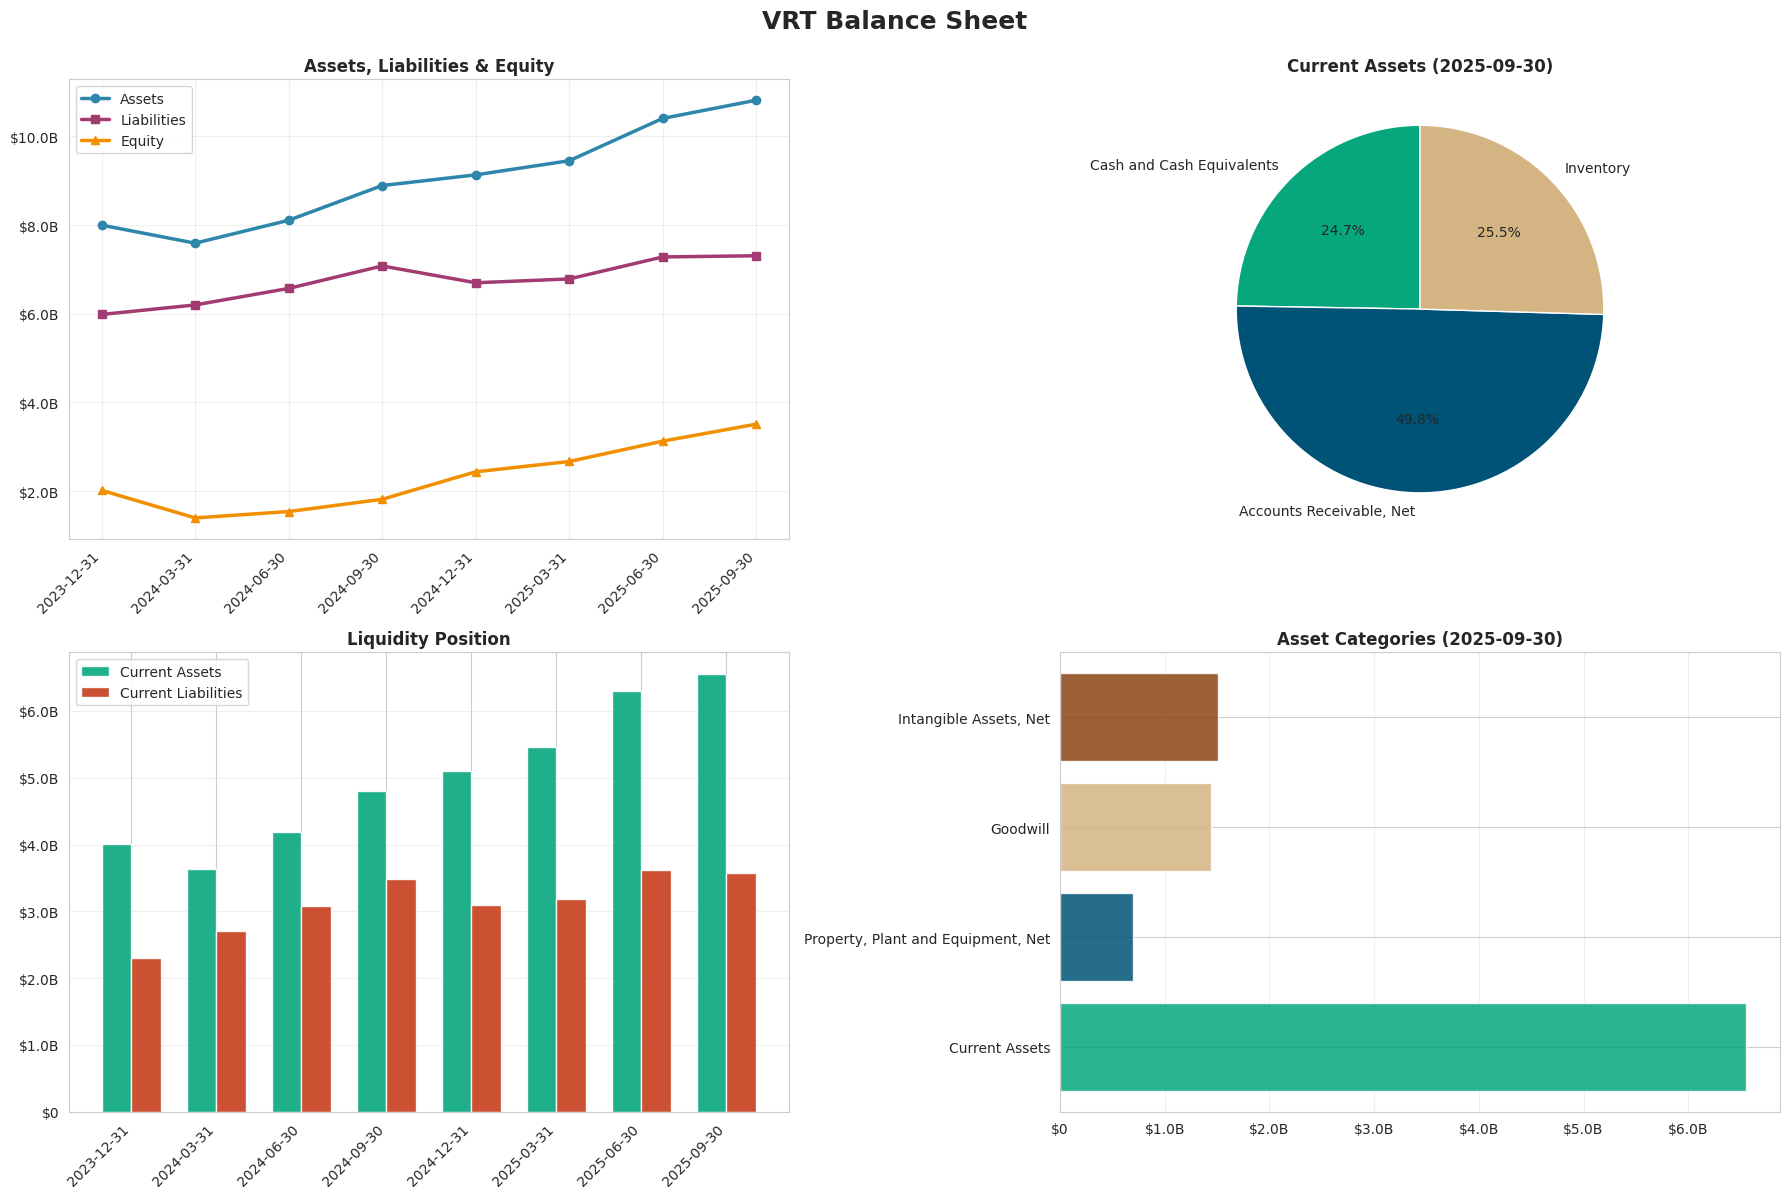

✓ Balance Sheet complete

📊 Income Statement visualizations...


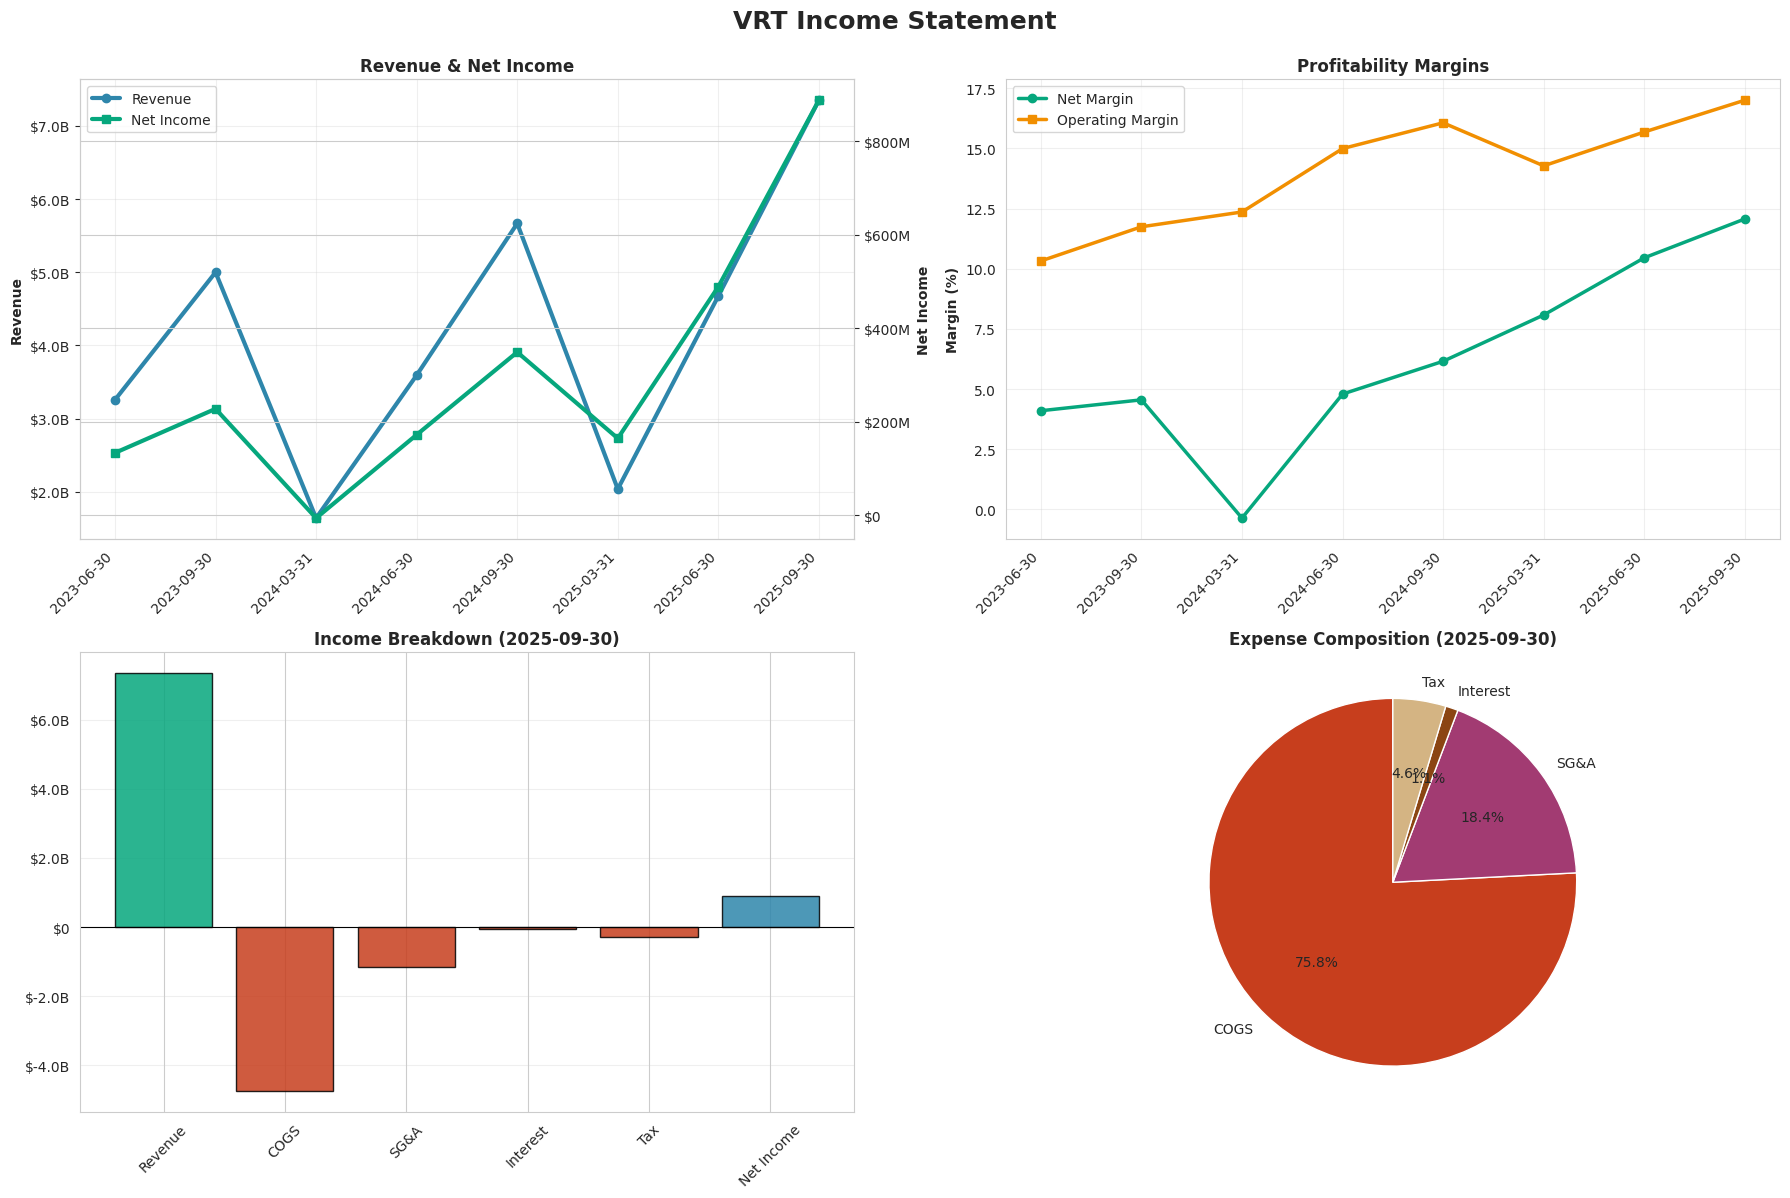

✓ Income Statement complete

📊 Cash Flow visualizations...


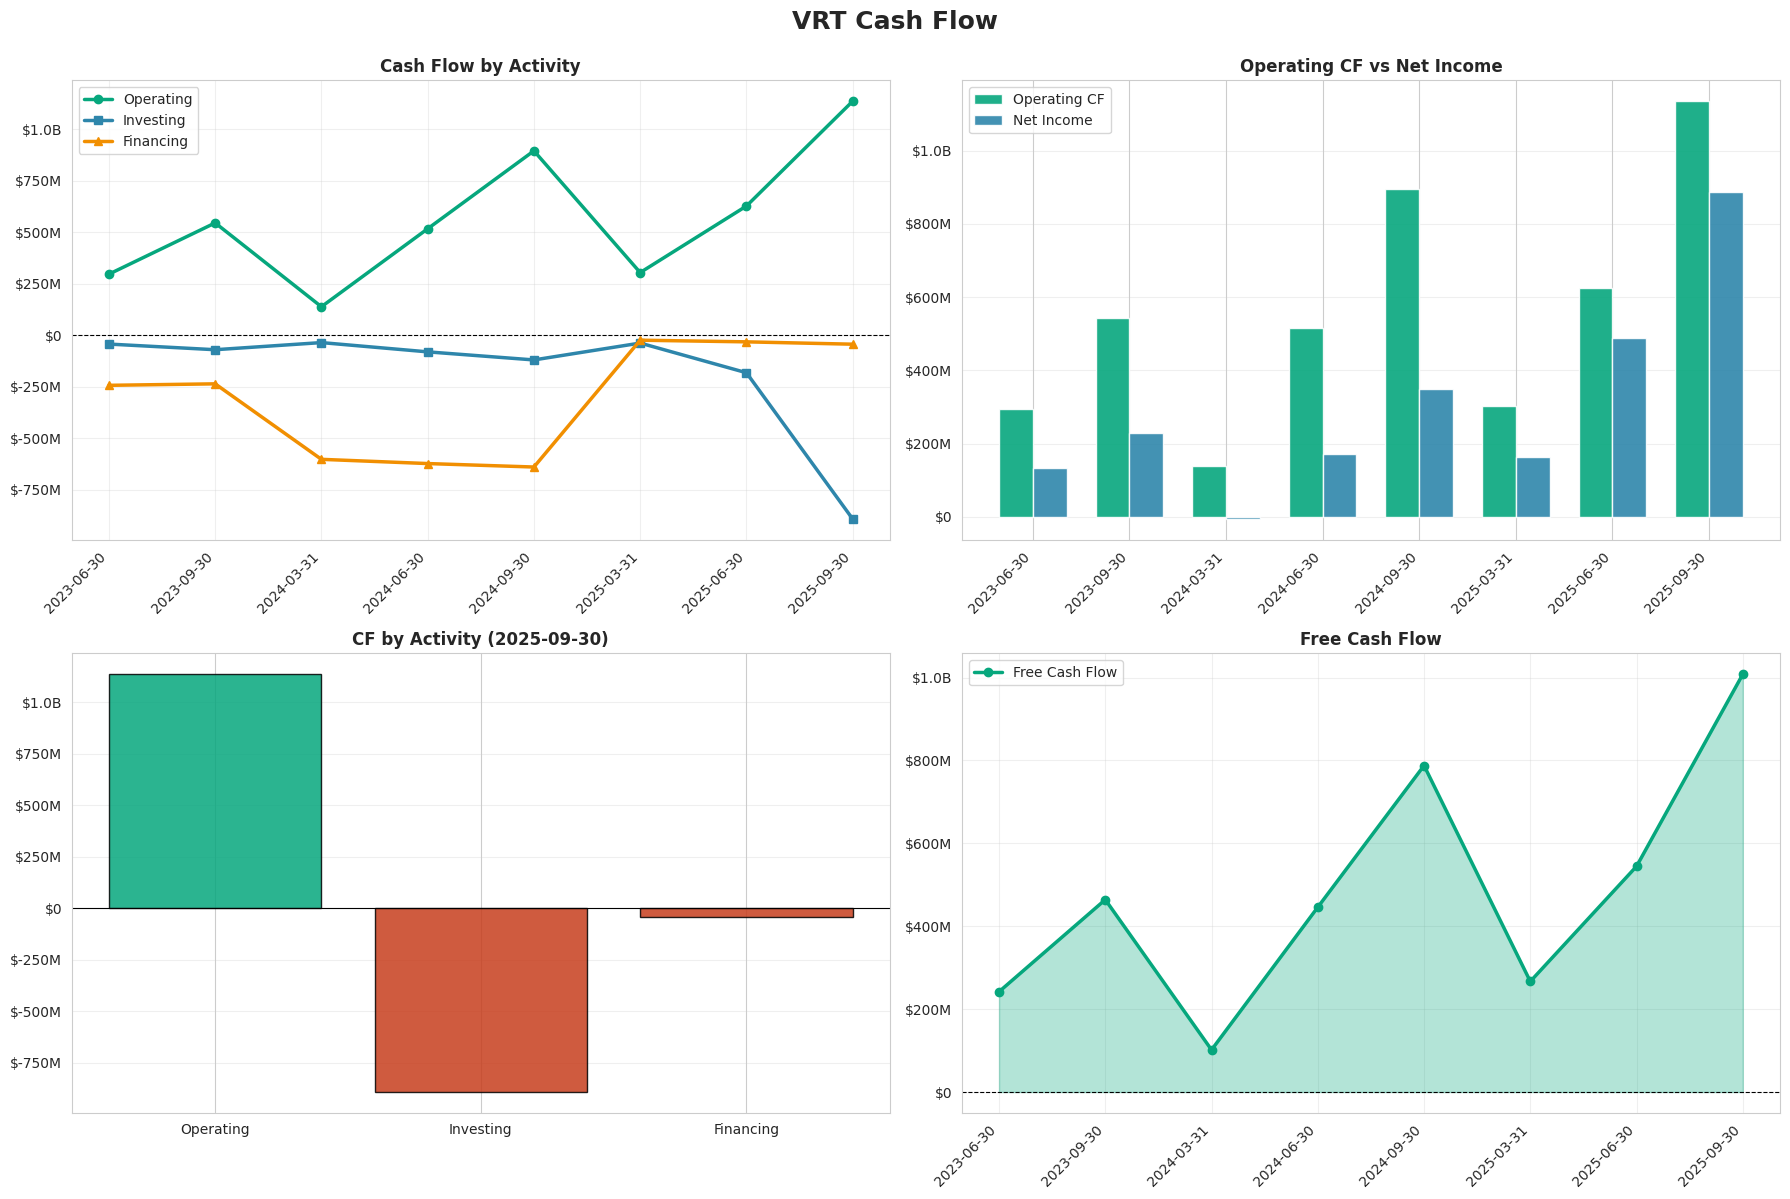

✓ Cash Flow complete

📊 Financial Ratios visualizations (ALL 21 RATIOS)...


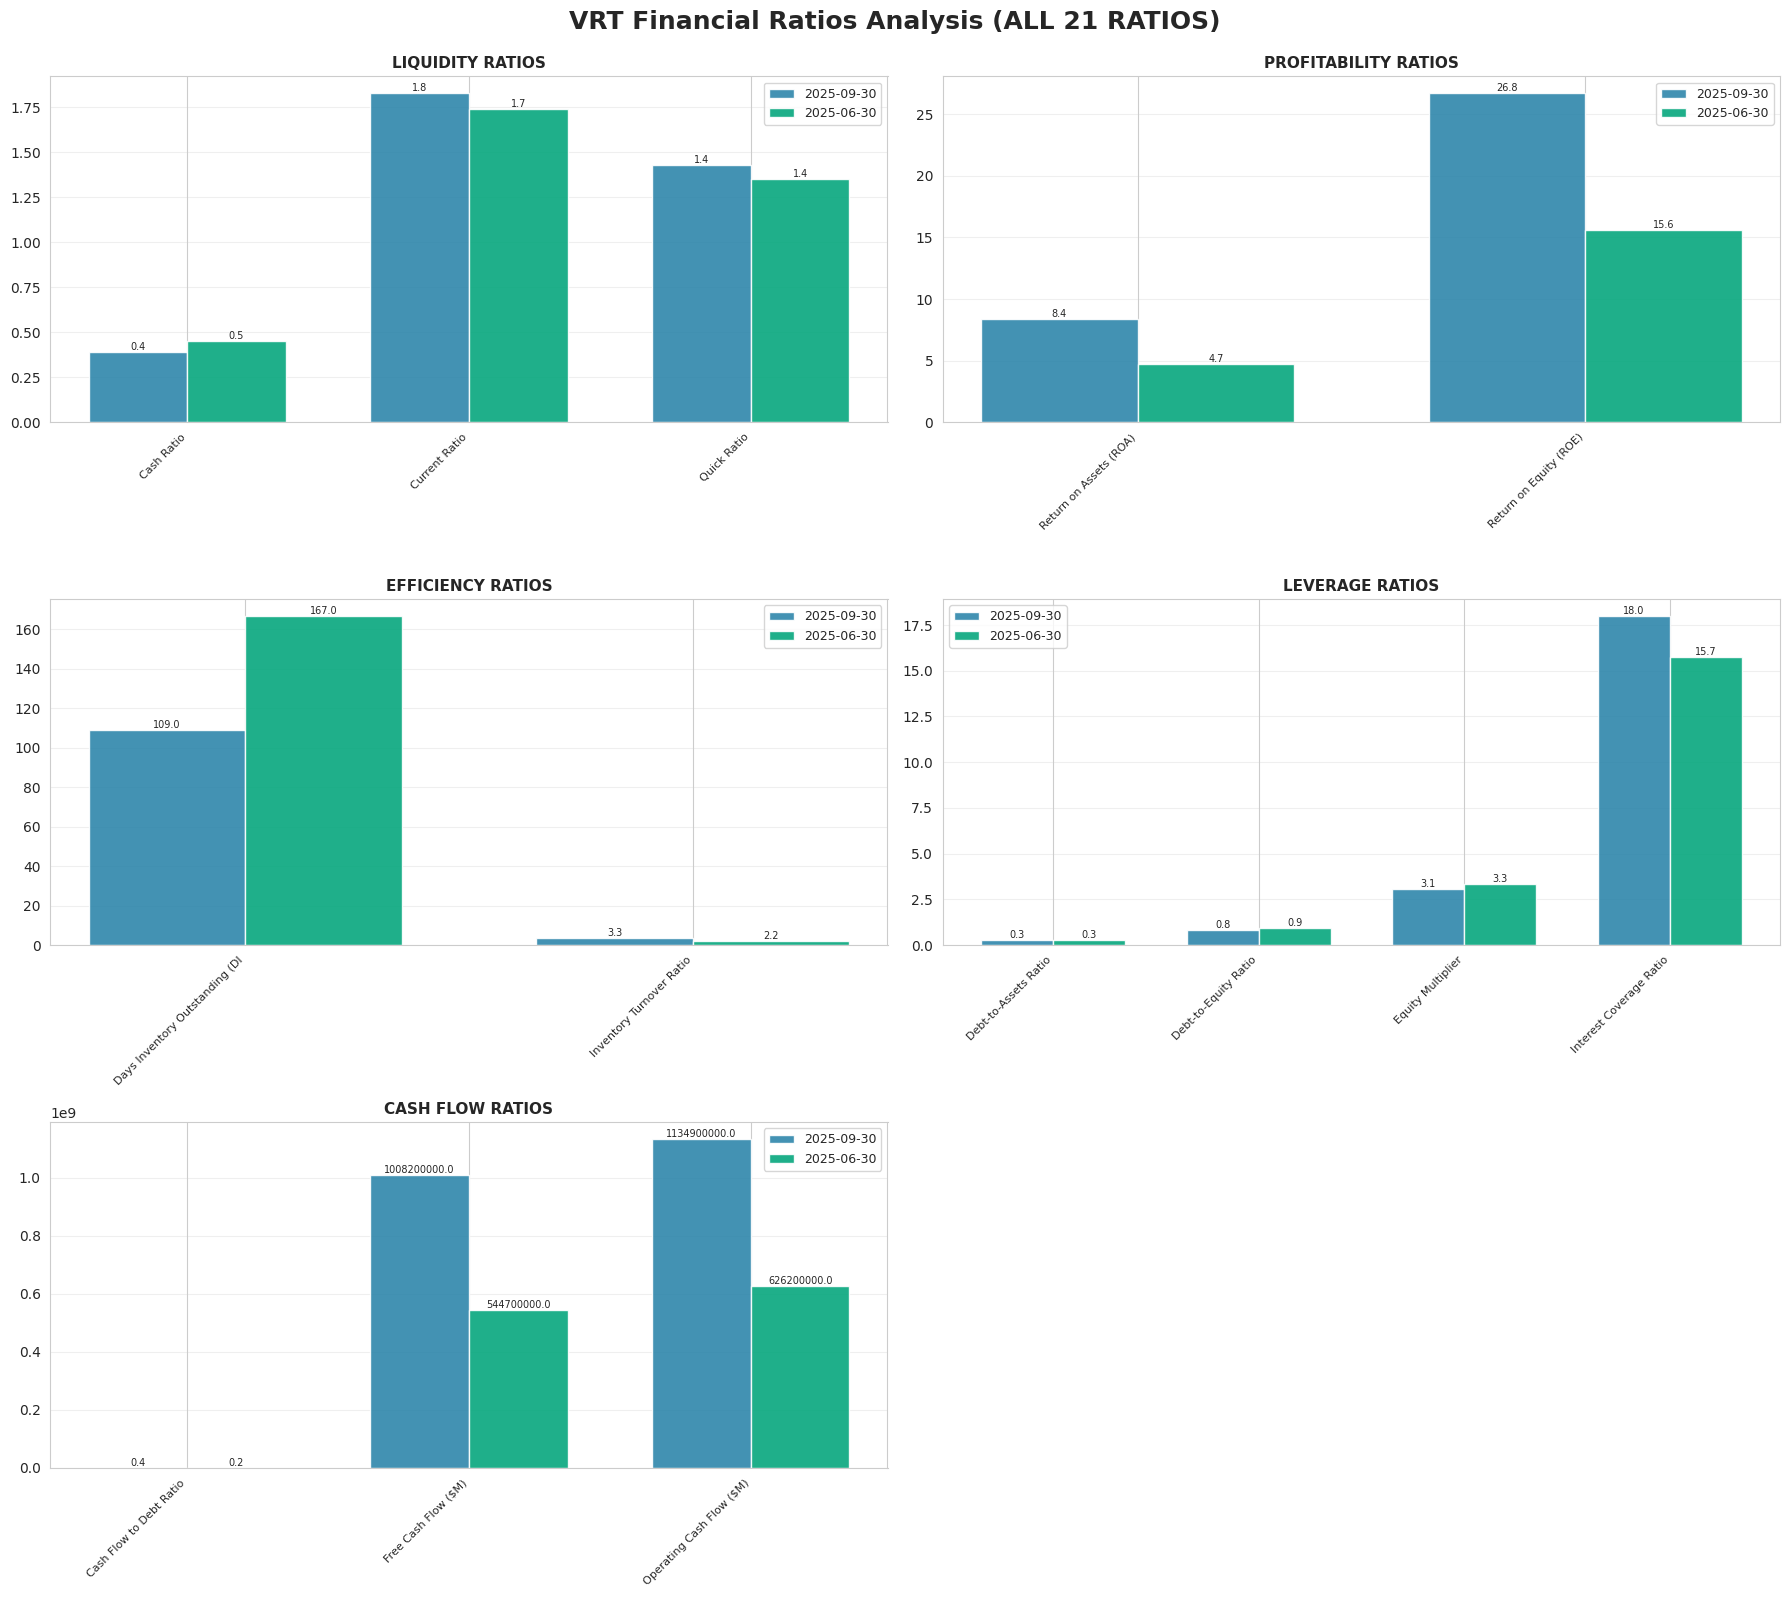

✓ Financial Ratios complete

✓ ALL VISUALIZATIONS COMPLETE FOR VRT
  - Balance Sheet: 4 charts
  - Income Statement: 4 charts
  - Cash Flow: 4 charts
  - Financial Ratios: ALL 21+ ratios displayed
  - TOTAL: 16 professional charts


In [ ]:

# STEP 6: FINANCIAL VISUALIZATIONS (14 RATIOS)
# ==============================================================================
!pip install matplotlib seaborn scikit-learn -q

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

ticker_viz = input("Enter ticker (e.g., VRT): ").strip()
excel_file = f'{ticker_viz}_10Q_Financials.xlsx'

print(f"\n{'='*80}")
print(f"GENERATING VISUALIZATIONS FOR {ticker_viz}")
print(f"{'='*80}\n")

def to_float(val):
    if pd.isna(val) or val == '' or val == 'NaN':
        return 0.0
    if isinstance(val, (int, float)):
        return float(val)
    return float(str(val).replace(',', ''))

def currency_formatter(x, pos):
    if abs(x) >= 1e9:
        return f'${x/1e9:.1f}B'
    elif abs(x) >= 1e6:
        return f'${x/1e6:.0f}M'
    elif abs(x) >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

def get_ratio(ratio_df, name, period):
    """Safely get ratio value"""
    row = ratio_df[ratio_df['Financial Ratio'] == name]
    if row.empty:
        return None
    val = row[period].values[0]
    if pd.isna(val) or val == '':
        return None
    # Clean value
    val_str = str(val).replace('%', '').replace(' days', '').replace(',', '').strip()
    try:
        return float(val_str)
    except:
        return None




# 1. BALANCE SHEET
# ==============================================================================
print("📊 Balance Sheet visualizations...")
bs_df = pd.read_excel(excel_file, sheet_name='Balance Sheet')
date_cols = [col for col in bs_df.columns if col != 'Line Item'][:8][::-1]

fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))
fig1.suptitle(f'{ticker_viz} Balance Sheet', fontsize=18, fontweight='bold', y=0.995)

# Assets/Liabilities/Equity
assets = [to_float(bs_df[bs_df['Line Item'] == 'Assets'][col].values[0]) for col in date_cols]
liabilities = [to_float(bs_df[bs_df['Line Item'] == 'Total Liabilities'][col].values[0]) for col in date_cols]
equity = [to_float(bs_df[bs_df['Line Item'] == 'Stockholders\' Equity'][col].values[0]) for col in date_cols]

x = range(len(date_cols))
axes1[0, 0].plot(x, assets, marker='o', linewidth=2.5, label='Assets', color='#2E86AB')
axes1[0, 0].plot(x, liabilities, marker='s', linewidth=2.5, label='Liabilities', color='#A23B72')
axes1[0, 0].plot(x, equity, marker='^', linewidth=2.5, label='Equity', color='#F18F01')
axes1[0, 0].set_xticks(x)
axes1[0, 0].set_xticklabels(date_cols, rotation=45, ha='right')
axes1[0, 0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes1[0, 0].set_title('Assets, Liabilities & Equity', fontweight='bold')
axes1[0, 0].legend()
axes1[0, 0].grid(True, alpha=0.3)

# Current Assets Composition
ca_items = ['Cash and Cash Equivalents', 'Accounts Receivable, Net', 'Inventory']
ca_vals = []
for item in ca_items:
    row = bs_df[bs_df['Line Item'] == item]
    ca_vals.append(to_float(row[date_cols[-1]].values[0]) if not row.empty else 0)

axes1[0, 1].pie(ca_vals, labels=ca_items, autopct='%1.1f%%', startangle=90,
                colors=['#06A77D', '#005377', '#D4B483'])
axes1[0, 1].set_title(f'Current Assets ({date_cols[-1]})', fontweight='bold')

# Liquidity Position
curr_assets = [to_float(bs_df[bs_df['Line Item'] == 'Current Assets'][col].values[0]) for col in date_cols]
curr_liab = [to_float(bs_df[bs_df['Line Item'] == 'Current Liabilities'][col].values[0]) for col in date_cols]

x2 = np.arange(len(date_cols))
w = 0.35
axes1[1, 0].bar(x2 - w/2, curr_assets, w, label='Current Assets', color='#06A77D', alpha=0.9)
axes1[1, 0].bar(x2 + w/2, curr_liab, w, label='Current Liabilities', color='#C73E1D', alpha=0.9)
axes1[1, 0].set_xticks(x2)
axes1[1, 0].set_xticklabels(date_cols, rotation=45, ha='right')
axes1[1, 0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes1[1, 0].set_title('Liquidity Position', fontweight='bold')
axes1[1, 0].legend()
axes1[1, 0].grid(True, alpha=0.3, axis='y')

# Asset Categories
asset_cats = ['Current Assets', 'Property, Plant and Equipment, Net', 'Goodwill', 'Intangible Assets, Net']
asset_vals = []
for item in asset_cats:
    row = bs_df[bs_df['Line Item'] == item]
    asset_vals.append(to_float(row[date_cols[-1]].values[0]) if not row.empty else 0)

axes1[1, 1].barh(asset_cats, asset_vals, color=['#06A77D', '#005377', '#D4B483', '#8B4513'], alpha=0.85)
axes1[1, 1].xaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes1[1, 1].set_title(f'Asset Categories ({date_cols[-1]})', fontweight='bold')
axes1[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()
print("✓ Balance Sheet complete\n")




# 2. INCOME STATEMENT
# ==============================================================================
print("📊 Income Statement visualizations...")
is_df = pd.read_excel(excel_file, sheet_name='Income Statement')
is_date_cols = [col for col in is_df.columns if col != 'Line Item'][:8][::-1]

fig2, axes2 = plt.subplots(2, 2, figsize=(18, 12))
fig2.suptitle(f'{ticker_viz} Income Statement', fontsize=18, fontweight='bold', y=0.995)

# Revenue & Net Income
revenue_rows = is_df[is_df['Line Item'] == 'Revenue']
revenue = [to_float(revenue_rows.iloc[1][col]) for col in is_date_cols]
net_income = [to_float(is_df[is_df['Line Item'] == 'Net Income'][col].values[0]) for col in is_date_cols]

x3 = range(len(is_date_cols))
ax2_twin = axes2[0, 0].twinx()
line1 = axes2[0, 0].plot(x3, revenue, marker='o', linewidth=3, label='Revenue', color='#2E86AB')
line2 = ax2_twin.plot(x3, net_income, marker='s', linewidth=3, label='Net Income', color='#06A77D')
axes2[0, 0].set_xticks(x3)
axes2[0, 0].set_xticklabels(is_date_cols, rotation=45, ha='right')
axes2[0, 0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax2_twin.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes2[0, 0].set_ylabel('Revenue', fontweight='bold')
ax2_twin.set_ylabel('Net Income', fontweight='bold')
axes2[0, 0].set_title('Revenue & Net Income', fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
axes2[0, 0].legend(lines, labels, loc='upper left')
axes2[0, 0].grid(True, alpha=0.3)

# Profit Margins
operating_income = [to_float(is_df[is_df['Line Item'] == 'Operating Income'][col].values[0]) for col in is_date_cols]
profit_margin = [(net_income[i] / revenue[i] * 100) if revenue[i] != 0 else 0 for i in range(len(revenue))]
operating_margin = [(operating_income[i] / revenue[i] * 100) if revenue[i] != 0 else 0 for i in range(len(revenue))]

axes2[0, 1].plot(x3, profit_margin, marker='o', linewidth=2.5, label='Net Margin', color='#06A77D')
axes2[0, 1].plot(x3, operating_margin, marker='s', linewidth=2.5, label='Operating Margin', color='#F18F01')
axes2[0, 1].set_xticks(x3)
axes2[0, 1].set_xticklabels(is_date_cols, rotation=45, ha='right')
axes2[0, 1].set_ylabel('Margin (%)', fontweight='bold')
axes2[0, 1].set_title('Profitability Margins', fontweight='bold')
axes2[0, 1].legend()
axes2[0, 1].grid(True, alpha=0.3)

# Income Breakdown
latest_revenue = revenue[-1]
latest_cogs = to_float(is_df[is_df['Line Item'] == 'Cost of Sales'][is_date_cols[-1]].values[0])
latest_sga = to_float(is_df[is_df['Line Item'] == 'Selling, General and Administrative'][is_date_cols[-1]].values[0])
latest_interest = to_float(is_df[is_df['Line Item'] == 'Interest Expense'][is_date_cols[-1]].values[0])
latest_tax = to_float(is_df[is_df['Line Item'] == 'Income Tax Expense'][is_date_cols[-1]].values[0])

categories = ['Revenue', 'COGS', 'SG&A', 'Interest', 'Tax', 'Net Income']
values = [latest_revenue, -latest_cogs, -latest_sga, -latest_interest, -latest_tax, net_income[-1]]
colors = ['#06A77D', '#C73E1D', '#C73E1D', '#C73E1D', '#C73E1D', '#2E86AB']

axes2[1, 0].bar(categories, values, color=colors, alpha=0.85, edgecolor='black')
axes2[1, 0].axhline(y=0, color='black', linewidth=0.8)
axes2[1, 0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes2[1, 0].set_title(f'Income Breakdown ({is_date_cols[-1]})', fontweight='bold')
axes2[1, 0].tick_params(axis='x', rotation=45)
axes2[1, 0].grid(True, alpha=0.3, axis='y')

# Expense Composition
exp_cats = ['COGS', 'SG&A', 'Interest', 'Tax']
exp_vals = [latest_cogs, latest_sga, latest_interest, latest_tax]

axes2[1, 1].pie(exp_vals, labels=exp_cats, autopct='%1.1f%%', startangle=90,
                colors=['#C73E1D', '#A23B72', '#8B4513', '#D4B483'])
axes2[1, 1].set_title(f'Expense Composition ({is_date_cols[-1]})', fontweight='bold')

plt.tight_layout()
plt.show()
print("✓ Income Statement complete\n")






# 3. CASH FLOW
# ==============================================================================
print("📊 Cash Flow visualizations...")
cf_df = pd.read_excel(excel_file, sheet_name='Cash Flow')
cf_date_cols = [col for col in cf_df.columns if col != 'Line Item'][:8][::-1]

fig3, axes3 = plt.subplots(2, 2, figsize=(18, 12))
fig3.suptitle(f'{ticker_viz} Cash Flow', fontsize=18, fontweight='bold', y=0.995)

# Cash Flow by Activity
cf_op = [to_float(cf_df[cf_df['Line Item'] == 'Net Cash from Operating Activities'][col].values[0]) for col in cf_date_cols]
cf_inv = [to_float(cf_df[cf_df['Line Item'] == 'Net Cash from Investing Activities'][col].values[0]) for col in cf_date_cols]
cf_fin = [to_float(cf_df[cf_df['Line Item'] == 'Net Cash from Financing Activities'][col].values[0]) for col in cf_date_cols]

x4 = range(len(cf_date_cols))
axes3[0, 0].plot(x4, cf_op, marker='o', linewidth=2.5, label='Operating', color='#06A77D')
axes3[0, 0].plot(x4, cf_inv, marker='s', linewidth=2.5, label='Investing', color='#2E86AB')
axes3[0, 0].plot(x4, cf_fin, marker='^', linewidth=2.5, label='Financing', color='#F18F01')
axes3[0, 0].axhline(y=0, color='black', linewidth=0.8, linestyle='--')
axes3[0, 0].set_xticks(x4)
axes3[0, 0].set_xticklabels(cf_date_cols, rotation=45, ha='right')
axes3[0, 0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes3[0, 0].set_title('Cash Flow by Activity', fontweight='bold')
axes3[0, 0].legend()
axes3[0, 0].grid(True, alpha=0.3)

# Operating CF vs Net Income
cf_ni = [to_float(cf_df[cf_df['Line Item'] == 'Net Income'][col].values[0]) for col in cf_date_cols]

x5 = np.arange(len(cf_date_cols))
w2 = 0.35
axes3[0, 1].bar(x5 - w2/2, cf_op, w2, label='Operating CF', color='#06A77D', alpha=0.9)
axes3[0, 1].bar(x5 + w2/2, cf_ni, w2, label='Net Income', color='#2E86AB', alpha=0.9)
axes3[0, 1].set_xticks(x5)
axes3[0, 1].set_xticklabels(cf_date_cols, rotation=45, ha='right')
axes3[0, 1].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes3[0, 1].set_title('Operating CF vs Net Income', fontweight='bold')
axes3[0, 1].legend()
axes3[0, 1].grid(True, alpha=0.3, axis='y')

# CF Composition
cf_cats = ['Operating', 'Investing', 'Financing']
cf_vals = [cf_op[-1], cf_inv[-1], cf_fin[-1]]
cf_colors = ['#06A77D' if v > 0 else '#C73E1D' for v in cf_vals]

axes3[1, 0].bar(cf_cats, cf_vals, color=cf_colors, alpha=0.85, edgecolor='black')
axes3[1, 0].axhline(y=0, color='black', linewidth=0.8)
axes3[1, 0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes3[1, 0].set_title(f'CF by Activity ({cf_date_cols[-1]})', fontweight='bold')
axes3[1, 0].grid(True, alpha=0.3, axis='y')

# Free Cash Flow
capex = [to_float(cf_df[cf_df['Line Item'] == 'Capital Expenditures'][col].values[0]) for col in cf_date_cols]
fcf = [cf_op[i] - capex[i] for i in range(len(cf_op))]

axes3[1, 1].fill_between(x4, 0, fcf, alpha=0.3, color='#06A77D')
axes3[1, 1].plot(x4, fcf, marker='o', linewidth=2.5, color='#06A77D', label='Free Cash Flow')
axes3[1, 1].axhline(y=0, color='black', linewidth=0.8, linestyle='--')
axes3[1, 1].set_xticks(x4)
axes3[1, 1].set_xticklabels(cf_date_cols, rotation=45, ha='right')
axes3[1, 1].yaxis.set_major_formatter(FuncFormatter(currency_formatter))
axes3[1, 1].set_title('Free Cash Flow', fontweight='bold')
axes3[1, 1].legend()
axes3[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ Cash Flow complete\n")





# 4. FINANCIAL RATIOS (ALL 21 RATIOS)
# ==============================================================================
print("📊 Financial Ratios visualizations (ALL 21 RATIOS)...")
ratio_df = pd.read_excel(excel_file, sheet_name='Financial Ratios')
q1 = ratio_df.columns[1]
q2 = ratio_df.columns[2]

# Get all ratio categories and their ratios
all_ratios = {}
current_category = None
for idx, row in ratio_df.iterrows():
    ratio_name = row['Financial Ratio']
    if 'RATIOS' in str(ratio_name).upper():
        current_category = ratio_name
        all_ratios[current_category] = []
    elif current_category:
        v1 = get_ratio(ratio_df, ratio_name, q1)
        v2 = get_ratio(ratio_df, ratio_name, q2)
        if v1 is not None or v2 is not None:
            all_ratios[current_category].append({
                'name': ratio_name,
                'q1': v1 if v1 is not None else 0,
                'q2': v2 if v2 is not None else 0
            })

# Create comprehensive ratio visualization
fig4, axes4 = plt.subplots(3, 2, figsize=(18, 16))
fig4.suptitle(f'{ticker_viz} Financial Ratios Analysis (ALL 21 RATIOS)', fontsize=18, fontweight='bold', y=0.995)

plot_idx = 0
for category, ratios in all_ratios.items():
    if plot_idx >= 6 or not ratios:
        continue

    row = plot_idx // 2
    col = plot_idx % 2
    ax = axes4[row, col]

    # Prepare data
    names = [r['name'][:30] for r in ratios]  # Truncate long names
    q1_vals = [r['q1'] for r in ratios]
    q2_vals = [r['q2'] for r in ratios]

    # Plot
    x_pos = np.arange(len(names))
    width = 0.35

    ax.bar(x_pos - width/2, q1_vals, width, label=q1, color='#2E86AB', alpha=0.9)
    ax.bar(x_pos + width/2, q2_vals, width, label=q2, color='#06A77D', alpha=0.9)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax.set_title(category, fontweight='bold', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, (v1, v2) in enumerate(zip(q1_vals, q2_vals)):
        if v1 != 0:
            ax.text(i - width/2, v1, f'{v1:.1f}', ha='center', va='bottom', fontsize=7)
        if v2 != 0:
            ax.text(i + width/2, v2, f'{v2:.1f}', ha='center', va='bottom', fontsize=7)

    plot_idx += 1

# Hide empty subplots
for i in range(plot_idx, 6):
    axes4[i//2, i%2].axis('off')

plt.tight_layout()
plt.show()
print("✓ Financial Ratios complete\n")

print(f"{'='*80}")
print(f"✓ ALL VISUALIZATIONS COMPLETE FOR {ticker_viz}")
print(f"  - Balance Sheet: 4 charts")
print(f"  - Income Statement: 4 charts")
print(f"  - Cash Flow: 4 charts")
print(f"  - Financial Ratios: ALL 21+ ratios displayed")
print(f"  - TOTAL: 16 professional charts")
print(f"{'='*80}")


In [11]:
# ==============================================================================
# PDF EXPORT - Save All Visualizations and Auto-Download
# ==============================================================================

print("\n" + "="*80)
print("GENERATING PDF EXPORT OF ALL VISUALIZATIONS")
print("="*80 + "\n")

# Import required libraries
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files
from datetime import datetime

# Generate filename with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
pdf_filename = f'{ticker_viz}_Financial_Analysis_{timestamp}.pdf'

# Create PDF with all figures
print(f"📄 Creating PDF: {pdf_filename}")
with PdfPages(pdf_filename) as pdf:
    # Page 1: Balance Sheet (4 charts)
    print("  Adding Balance Sheet...")
    pdf.savefig(fig1, dpi=300, bbox_inches='tight')

    # Page 2: Income Statement (4 charts)
    print("  Adding Income Statement...")
    pdf.savefig(fig2, dpi=300, bbox_inches='tight')

    # Page 3: Cash Flow (4 charts)
    print("  Adding Cash Flow...")
    pdf.savefig(fig3, dpi=300, bbox_inches='tight')

    # Page 4: Financial Ratios (ALL 21 ratios)
    print("  Adding Financial Ratios (ALL 21)...")
    pdf.savefig(fig4, dpi=300, bbox_inches='tight')

    # Add metadata
    d = pdf.infodict()
    d['Title'] = f'{ticker_viz} Financial Analysis'
    d['Author'] = 'Alex Osterneck, CLA, MSCS, MSIT'
    d['Subject'] = 'SEC 10-Q Financial Analysis with Ratios & Visualizations'
    d['Keywords'] = f'{ticker_viz}, Financial Analysis, SEC 10-Q'
    d['CreationDate'] = datetime.now()

print(f"\n✓ PDF created successfully: {pdf_filename}")
print(f"  Total pages: 4")
print(f"  Resolution: 300 DPI (High Quality)")
print(f"  Color mode: Full Color")

# Display all figures one more time in color
print(f"\n{'='*80}")
print("DISPLAYING ALL VISUALIZATIONS IN COLOR")
print(f"{'='*80}\n")

print("📊 Figure 1: Balance Sheet (4 charts)")
fig1.show()

print("\n📊 Figure 2: Income Statement (4 charts)")
fig2.show()

print("\n📊 Figure 3: Cash Flow (4 charts)")
fig3.show()

print("\n📊 Figure 4: Financial Ratios (ALL 21 ratios)")
fig4.show()

# Auto-download the PDF
print(f"\n{'='*80}")
print("AUTO-DOWNLOADING PDF TO YOUR LOCAL MACHINE")
print(f"{'='*80}\n")
files.download(pdf_filename)
print(f"✓ Download initiated: {pdf_filename}")
print(f"  Check your browser's download folder\n")

print(f"{'='*80}")
print("✓ PDF EXPORT COMPLETE")
print(f"  File: {pdf_filename}")
print(f"  Contains: All 4 visualization pages in full color")
print(f"  Total Charts: 16 professional charts")
print(f"{'='*80}")



GENERATING PDF EXPORT OF ALL VISUALIZATIONS

📄 Creating PDF: VRT_Financial_Analysis_20251211_235901.pdf
  Adding Balance Sheet...
  Adding Income Statement...
  Adding Cash Flow...
  Adding Financial Ratios (ALL 21)...

✓ PDF created successfully: VRT_Financial_Analysis_20251211_235901.pdf
  Total pages: 4
  Resolution: 300 DPI (High Quality)
  Color mode: Full Color

DISPLAYING ALL VISUALIZATIONS IN COLOR

📊 Figure 1: Balance Sheet (4 charts)

📊 Figure 2: Income Statement (4 charts)

📊 Figure 3: Cash Flow (4 charts)

📊 Figure 4: Financial Ratios (ALL 21 ratios)

AUTO-DOWNLOADING PDF TO YOUR LOCAL MACHINE



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download initiated: VRT_Financial_Analysis_20251211_235901.pdf
  Check your browser's download folder

✓ PDF EXPORT COMPLETE
  File: VRT_Financial_Analysis_20251211_235901.pdf
  Contains: All 4 visualization pages in full color
  Total Charts: 16 professional charts
